# 目标检测数据集（皮卡丘）

在目标检测领域并没有类似 MNIST 或 Fashion-MNIST 那样的小数据集。为了快速测试模型，我们合成了一个小的数据集。我们首先使用一个开源的皮卡丘 3D 模型生成了 1000 张不同角度和大小的皮卡丘图像。然后我们收集了一系列背景图像，并在每张图的随机位置放置一张随机的皮卡丘图像。我们使用 MXNet 提供的 im2rec 工具将图像转换成二进制的 RecordIO 格式 [1]。该格式既可以降低数据集在磁盘上的存储开销，又能提高读取效率。如果你想了解更多的图像读取方法，可以查阅 GluonCV 工具包的文档 [2]。


## 下载数据集

RecordIO 格式的皮卡丘数据集可以直接在网上下载。下载数据集的操作定义在`_download_pikachu`函数中。

In [1]:
import sys
sys.path.insert(0, '..')

%matplotlib inline
import gluonbook as gb
from mxnet import gluon, image
from mxnet.gluon import utils as gutils
import os

def _download_pikachu(data_dir):
    root_url = ('https://apache-mxnet.s3-accelerate.amazonaws.com/'
                'gluon/dataset/pikachu/')
    dataset = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
               'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
               'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}
    for k, v in dataset.items():
        gutils.download(root_url + k, os.path.join(data_dir, k), sha1_hash=v)

C:\Users\lenovo\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 读取数据集

* 我们通过创建ImageDetIter实例读取目标数据集。其中名称里面‘Det’是指‘Detection’

In [5]:
def load_data_pikachu(batch_size,edge_size=256):
    data_dir ='../data/pikachu'

    train_iter = image.ImageDetIter(path_imgrec=os.path.join(data_dir,'train.rec'),
                                    path_imgidx=os.path.join(data_dir,'train.idx'),
                                    batch_size=batch_size,
                                    data_shape  = (3,edge_size,edge_size),#输出图像形状
                                    shuffle = False,
                                    rand_crop=1, #随机裁剪的概率为1
                                    min_object_covered = 0.95,max_attempts=200,
                                    )
    val_iter = image.ImageDetIter(
                                  path_imgrec=os.path.join(data_dir, 'val.rec'), batch_size=batch_size,
                                 data_shape=(3, edge_size, edge_size), shuffle=False)
    return train_iter,val_iter

In [20]:
test_train,_ = load_data_pikachu(64)

for i,batch in enumerate(test_train):
        print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


KeyboardInterrupt: 

In [8]:
test_train.reset()

In [19]:
batch = test_train.next()
batch = test_train.next()
batch = test_train.next()
batch = test_train.next()

下面我们读取一个小批量并打印图像和标签的形状。图像的形状和之前实验中的一样，依然是（批量大小，通道数，高，宽）。而标签的形状则是（批量大小，$m$，5），其中 $m$ 等于数据集中单个图像最多含有的边界框个数。小批量计算虽然高效，但它要求每张图像含有相同数量的边界框，以便放在同一个批量中。由于每张图像含有的边界框个数可能不同，我们为边界框个数小于 $m$ 的图像填充非法边界框，直到每张图像均含有 $m$ 个边界框。这样，我们就可以每次读取小批量的图像了。图像中每个边界框的标签由长度为 5 的数组表示。数组中第一个元素是边界框所含目标的类别。当值为 -1 时，该边界框为填充用的非法边界框。数组的剩余 4 个元素分别表示边界框左上角和右下角的 $x$ 和 $y$ 轴坐标（值域在 0 到 1 之间）。这里的皮卡丘数据集中每个图像只有一个边界框，因此 $m=1$。

In [5]:
batch_size, edge_size = 64, 256
train_iter, _ = load_data_pikachu(batch_size, edge_size)
train_iter.reshape(label_shape=(3,5))
batch = train_iter.next()
batch.data[0].shape, batch.label[0].shape

((64, 3, 256, 256), (64, 3, 5))

In [17]:
#获取皮卡丘数据
batch_size = 64
train_iter,test_iter = gb.load_data_pikachu(batch_size)

In [19]:
train_iter.reset()
for i,batch in enumerate(train_iter):
        print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


KeyboardInterrupt: 

## 图示数据

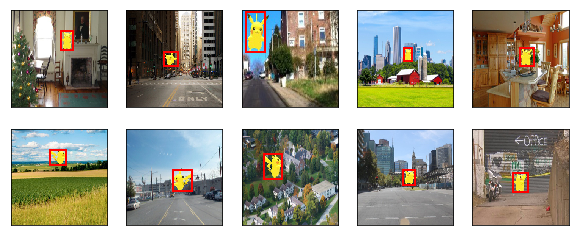

In [11]:
imgs = (batch.data[0][0:10].transpose((0,2,3,1))) / 255
axes = gb.show_images(imgs,2,5).flatten()
for ax,label in zip(axes,batch.label[0][0:10]):
    gb.show_bboxes(ax,[label[0][1:5]*edge_size],colors=['r'])